In [1]:
EXPERIMENT = '03-02'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

# Cross validation

## Preparation

In [13]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [14]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [15]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [16]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [17]:
train.set_index('id', inplace=True)

## Training models

In [18]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    with timer('Training', logger):
        estimator = CatBoostRegressor(n_estimators=300, random_state=SEED,
                                      train_dir=os.path.join(output_dir, f'fold{num_fold}'),
                                      cat_features=discrete_features)
        estimator.fit(X_train, y_train, sample_weight=y_train + 1)
    
    # 予測結果を保存する
    with timer('Prediction', logger):
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_test = pd.DataFrame(data=estimator.predict(X_test.drop(columns=['id'])), columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump(estimator, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.191486
0:	learn: 0.6695814	total: 206ms	remaining: 1m 1s
1:	learn: 0.6220579	total: 278ms	remaining: 41.5s
2:	learn: 0.5840892	total: 340ms	remaining: 33.7s
3:	learn: 0.5507452	total: 403ms	remaining: 29.8s
4:	learn: 0.5237456	total: 473ms	remaining: 27.9s
5:	learn: 0.5028328	total: 530ms	remaining: 26s
6:	learn: 0.4875332	total: 585ms	remaining: 24.5s
7:	learn: 0.4762932	total: 649ms	remaining: 23.7s
8:	learn: 0.4676801	total: 714ms	remaining: 23.1s
9:	learn: 0.4572204	total: 791ms	remaining: 22.9s
10:	learn: 0.4512099	total: 858ms	remaining: 22.5s
11:	learn: 0.4458898	total: 939ms	remaining: 22.5s
12:	learn: 0.4413066	total: 1.01s	remaining: 22.3s
13:	learn: 0.4377333	total: 1.07s	remaining: 21.9s
14:	learn: 0.4351268	total: 1.14s	remaining: 21.6s
15:	learn: 0.4323362	total: 1.19s	remaining: 21.2s
16:	learn: 0.4295386	total: 1.25s	remaining: 20.9s
17:	learn: 0.4278508	total: 1.31s	remaining: 20.5s
18:	learn: 0.4259844	total: 1.37s	remaining: 20.3s
19:	learn: 0.

160:	learn: 0.3664721	total: 9.52s	remaining: 8.22s
161:	learn: 0.3663319	total: 9.57s	remaining: 8.15s
162:	learn: 0.3662103	total: 9.62s	remaining: 8.09s
163:	learn: 0.3660119	total: 9.69s	remaining: 8.04s
164:	learn: 0.3658168	total: 9.75s	remaining: 7.98s
165:	learn: 0.3656138	total: 9.8s	remaining: 7.92s
166:	learn: 0.3655158	total: 9.86s	remaining: 7.85s
167:	learn: 0.3652817	total: 9.91s	remaining: 7.79s
168:	learn: 0.3651382	total: 10s	remaining: 7.75s
169:	learn: 0.3648355	total: 10.1s	remaining: 7.69s
170:	learn: 0.3647147	total: 10.1s	remaining: 7.63s
171:	learn: 0.3646620	total: 10.2s	remaining: 7.56s
172:	learn: 0.3644339	total: 10.2s	remaining: 7.5s
173:	learn: 0.3642147	total: 10.3s	remaining: 7.44s
174:	learn: 0.3639441	total: 10.3s	remaining: 7.37s
175:	learn: 0.3637323	total: 10.4s	remaining: 7.31s
176:	learn: 0.3636374	total: 10.4s	remaining: 7.25s
177:	learn: 0.3634498	total: 10.5s	remaining: 7.18s
178:	learn: 0.3631906	total: 10.5s	remaining: 7.12s
179:	learn: 0.36

20:	learn: 0.4223709	total: 1.42s	remaining: 18.9s
21:	learn: 0.4207846	total: 1.47s	remaining: 18.6s
22:	learn: 0.4198909	total: 1.53s	remaining: 18.5s
23:	learn: 0.4188514	total: 1.59s	remaining: 18.3s
24:	learn: 0.4173709	total: 1.67s	remaining: 18.3s
25:	learn: 0.4164263	total: 1.72s	remaining: 18.1s
26:	learn: 0.4157561	total: 1.77s	remaining: 17.9s
27:	learn: 0.4150836	total: 1.82s	remaining: 17.7s
28:	learn: 0.4142901	total: 1.87s	remaining: 17.5s
29:	learn: 0.4132153	total: 1.93s	remaining: 17.4s
30:	learn: 0.4125182	total: 1.98s	remaining: 17.2s
31:	learn: 0.4117442	total: 2.04s	remaining: 17.1s
32:	learn: 0.4113216	total: 2.1s	remaining: 17s
33:	learn: 0.4105155	total: 2.15s	remaining: 16.9s
34:	learn: 0.4099808	total: 2.21s	remaining: 16.7s
35:	learn: 0.4085276	total: 2.27s	remaining: 16.6s
36:	learn: 0.4075645	total: 2.32s	remaining: 16.5s
37:	learn: 0.4070826	total: 2.37s	remaining: 16.4s
38:	learn: 0.4067118	total: 2.42s	remaining: 16.2s
39:	learn: 0.4055419	total: 2.48s	

180:	learn: 0.3629804	total: 11.5s	remaining: 7.58s
181:	learn: 0.3628486	total: 11.6s	remaining: 7.51s
182:	learn: 0.3626519	total: 11.7s	remaining: 7.45s
183:	learn: 0.3623839	total: 11.7s	remaining: 7.39s
184:	learn: 0.3621222	total: 11.8s	remaining: 7.33s
185:	learn: 0.3620242	total: 11.9s	remaining: 7.27s
186:	learn: 0.3619327	total: 11.9s	remaining: 7.21s
187:	learn: 0.3617904	total: 12s	remaining: 7.14s
188:	learn: 0.3616639	total: 12.1s	remaining: 7.08s
189:	learn: 0.3615411	total: 12.1s	remaining: 7.02s
190:	learn: 0.3613425	total: 12.2s	remaining: 6.95s
191:	learn: 0.3610754	total: 12.3s	remaining: 6.89s
192:	learn: 0.3608876	total: 12.3s	remaining: 6.83s
193:	learn: 0.3606934	total: 12.4s	remaining: 6.77s
194:	learn: 0.3605971	total: 12.5s	remaining: 6.72s
195:	learn: 0.3604917	total: 12.6s	remaining: 6.66s
196:	learn: 0.3603753	total: 12.6s	remaining: 6.6s
197:	learn: 0.3603256	total: 12.7s	remaining: 6.54s
198:	learn: 0.3601585	total: 12.8s	remaining: 6.48s
199:	learn: 0.3

40:	learn: 0.4054473	total: 2.68s	remaining: 17s
41:	learn: 0.4049379	total: 2.75s	remaining: 16.9s
42:	learn: 0.4040456	total: 2.82s	remaining: 16.9s
43:	learn: 0.4036083	total: 2.89s	remaining: 16.8s
44:	learn: 0.4032798	total: 2.95s	remaining: 16.7s
45:	learn: 0.4029965	total: 3.02s	remaining: 16.7s
46:	learn: 0.4025923	total: 3.09s	remaining: 16.6s
47:	learn: 0.4019047	total: 3.15s	remaining: 16.5s
48:	learn: 0.4012487	total: 3.21s	remaining: 16.5s
49:	learn: 0.4004475	total: 3.28s	remaining: 16.4s
50:	learn: 0.3999133	total: 3.36s	remaining: 16.4s
51:	learn: 0.3997642	total: 3.42s	remaining: 16.3s
52:	learn: 0.3991637	total: 3.5s	remaining: 16.3s
53:	learn: 0.3983609	total: 3.72s	remaining: 16.9s
54:	learn: 0.3979322	total: 3.78s	remaining: 16.8s
55:	learn: 0.3972755	total: 3.89s	remaining: 17s
56:	learn: 0.3968060	total: 4.03s	remaining: 17.2s
57:	learn: 0.3963664	total: 4.1s	remaining: 17.1s
58:	learn: 0.3957764	total: 4.16s	remaining: 17s
59:	learn: 0.3954067	total: 4.25s	remai

203:	learn: 0.3578428	total: 13.7s	remaining: 6.45s
204:	learn: 0.3577624	total: 13.8s	remaining: 6.37s
205:	learn: 0.3576266	total: 13.8s	remaining: 6.3s
206:	learn: 0.3575144	total: 13.9s	remaining: 6.23s
207:	learn: 0.3572856	total: 13.9s	remaining: 6.16s
208:	learn: 0.3572022	total: 14s	remaining: 6.08s
209:	learn: 0.3571096	total: 14s	remaining: 6.01s
210:	learn: 0.3569062	total: 14.1s	remaining: 5.95s
211:	learn: 0.3566782	total: 14.2s	remaining: 5.88s
212:	learn: 0.3565882	total: 14.2s	remaining: 5.81s
213:	learn: 0.3564086	total: 14.3s	remaining: 5.74s
214:	learn: 0.3562316	total: 14.3s	remaining: 5.67s
215:	learn: 0.3560484	total: 14.4s	remaining: 5.6s
216:	learn: 0.3558746	total: 14.5s	remaining: 5.53s
217:	learn: 0.3556875	total: 14.5s	remaining: 5.46s
218:	learn: 0.3555664	total: 14.6s	remaining: 5.39s
219:	learn: 0.3554881	total: 14.6s	remaining: 5.32s
220:	learn: 0.3552854	total: 14.7s	remaining: 5.25s
221:	learn: 0.3551647	total: 14.8s	remaining: 5.18s
222:	learn: 0.3548

66:	learn: 0.3922372	total: 4.18s	remaining: 14.5s
67:	learn: 0.3920883	total: 4.23s	remaining: 14.4s
68:	learn: 0.3915394	total: 4.29s	remaining: 14.4s
69:	learn: 0.3909379	total: 4.37s	remaining: 14.4s
70:	learn: 0.3906591	total: 4.43s	remaining: 14.3s
71:	learn: 0.3902188	total: 4.49s	remaining: 14.2s
72:	learn: 0.3898037	total: 4.57s	remaining: 14.2s
73:	learn: 0.3893404	total: 4.63s	remaining: 14.1s
74:	learn: 0.3891216	total: 4.69s	remaining: 14.1s
75:	learn: 0.3888870	total: 4.75s	remaining: 14s
76:	learn: 0.3886242	total: 4.81s	remaining: 13.9s
77:	learn: 0.3881193	total: 4.88s	remaining: 13.9s
78:	learn: 0.3876022	total: 4.93s	remaining: 13.8s
79:	learn: 0.3872294	total: 4.99s	remaining: 13.7s
80:	learn: 0.3867046	total: 5.06s	remaining: 13.7s
81:	learn: 0.3863470	total: 5.13s	remaining: 13.6s
82:	learn: 0.3858772	total: 5.18s	remaining: 13.6s
83:	learn: 0.3853256	total: 5.25s	remaining: 13.5s
84:	learn: 0.3849747	total: 5.3s	remaining: 13.4s
85:	learn: 0.3846308	total: 5.37s	

227:	learn: 0.3535243	total: 14.2s	remaining: 4.5s
228:	learn: 0.3532587	total: 14.3s	remaining: 4.44s
229:	learn: 0.3530891	total: 14.4s	remaining: 4.37s
230:	learn: 0.3528820	total: 14.4s	remaining: 4.31s
231:	learn: 0.3526345	total: 14.5s	remaining: 4.26s
232:	learn: 0.3523931	total: 14.6s	remaining: 4.19s
233:	learn: 0.3523304	total: 14.6s	remaining: 4.13s
234:	learn: 0.3522143	total: 14.7s	remaining: 4.07s
235:	learn: 0.3520660	total: 14.8s	remaining: 4.01s
236:	learn: 0.3519019	total: 14.8s	remaining: 3.95s
237:	learn: 0.3516705	total: 14.9s	remaining: 3.88s
238:	learn: 0.3514569	total: 15s	remaining: 3.82s
239:	learn: 0.3512833	total: 15s	remaining: 3.76s
240:	learn: 0.3511328	total: 15.1s	remaining: 3.7s
241:	learn: 0.3510344	total: 15.2s	remaining: 3.64s
242:	learn: 0.3508605	total: 15.2s	remaining: 3.57s
243:	learn: 0.3507069	total: 15.3s	remaining: 3.52s
244:	learn: 0.3505287	total: 15.4s	remaining: 3.45s
245:	learn: 0.3503346	total: 15.4s	remaining: 3.39s
246:	learn: 0.3501

90:	learn: 0.3819265	total: 5.57s	remaining: 12.8s
91:	learn: 0.3813469	total: 5.63s	remaining: 12.7s
92:	learn: 0.3809070	total: 5.69s	remaining: 12.7s
93:	learn: 0.3805968	total: 5.74s	remaining: 12.6s
94:	learn: 0.3802434	total: 5.81s	remaining: 12.5s
95:	learn: 0.3798328	total: 5.88s	remaining: 12.5s
96:	learn: 0.3796151	total: 5.95s	remaining: 12.5s
97:	learn: 0.3793088	total: 6.01s	remaining: 12.4s
98:	learn: 0.3791359	total: 6.08s	remaining: 12.3s
99:	learn: 0.3786708	total: 6.15s	remaining: 12.3s
100:	learn: 0.3783464	total: 6.21s	remaining: 12.2s
101:	learn: 0.3779238	total: 6.29s	remaining: 12.2s
102:	learn: 0.3777641	total: 6.35s	remaining: 12.2s
103:	learn: 0.3773324	total: 6.45s	remaining: 12.2s
104:	learn: 0.3770794	total: 6.51s	remaining: 12.1s
105:	learn: 0.3768455	total: 6.56s	remaining: 12s
106:	learn: 0.3766600	total: 6.62s	remaining: 11.9s
107:	learn: 0.3764694	total: 6.68s	remaining: 11.9s
108:	learn: 0.3762101	total: 6.74s	remaining: 11.8s
109:	learn: 0.3759872	to

251:	learn: 0.3483029	total: 15.8s	remaining: 3.01s
252:	learn: 0.3481804	total: 15.9s	remaining: 2.95s
253:	learn: 0.3480859	total: 15.9s	remaining: 2.88s
254:	learn: 0.3478973	total: 16s	remaining: 2.82s
255:	learn: 0.3477379	total: 16s	remaining: 2.75s
256:	learn: 0.3475845	total: 16.1s	remaining: 2.69s
257:	learn: 0.3474222	total: 16.1s	remaining: 2.63s
258:	learn: 0.3472464	total: 16.2s	remaining: 2.57s
259:	learn: 0.3471123	total: 16.3s	remaining: 2.5s
260:	learn: 0.3470021	total: 16.3s	remaining: 2.44s
261:	learn: 0.3468524	total: 16.4s	remaining: 2.38s
262:	learn: 0.3465977	total: 16.5s	remaining: 2.31s
263:	learn: 0.3464960	total: 16.5s	remaining: 2.25s
264:	learn: 0.3463370	total: 16.6s	remaining: 2.19s
265:	learn: 0.3462187	total: 16.6s	remaining: 2.13s
266:	learn: 0.3459347	total: 16.7s	remaining: 2.06s
267:	learn: 0.3457868	total: 16.8s	remaining: 2s
268:	learn: 0.3455460	total: 16.8s	remaining: 1.94s
269:	learn: 0.3454225	total: 16.9s	remaining: 1.88s
270:	learn: 0.345328

## Evaluation

In [19]:
rmse = partial(mse, squared=False)

In [20]:
metrics = defaultdict(list)

### Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-04 00:18:50,749 - __main__ - INFO - CV fold 1 training loss=93.9323813
2021-08-04 00:18:50,773 - __main__ - INFO - CV fold 2 training loss=93.4294564
2021-08-04 00:18:50,799 - __main__ - INFO - CV fold 3 training loss=92.7123656
2021-08-04 00:18:50,824 - __main__ - INFO - CV fold 4 training loss=92.0749723
2021-08-04 00:18:50,852 - __main__ - INFO - CV fold 5 training loss=91.7228735
2021-08-04 00:18:50,853 - __main__ - INFO - CV training loss: average=92.7744098, std=0.8208258


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [23]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-04 00:18:51,088 - __main__ - INFO - Training loss: 106.9862794


### Validation set

In [24]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-04 00:18:51,134 - __main__ - INFO - CV fold 1 validation loss=100.2972307
2021-08-04 00:18:51,146 - __main__ - INFO - CV fold 2 validation loss=104.1794079
2021-08-04 00:18:51,157 - __main__ - INFO - CV fold 3 validation loss=106.0356690
2021-08-04 00:18:51,204 - __main__ - INFO - CV fold 4 validation loss=106.5602693
2021-08-04 00:18:51,216 - __main__ - INFO - CV fold 5 validation loss=109.1716701
2021-08-04 00:18:51,216 - __main__ - INFO - CV validation loss: average=105.2488494, std=2.9458331


In [25]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [26]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-04 00:18:51,443 - __main__ - INFO - Validation loss: 198.3832412


In [27]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


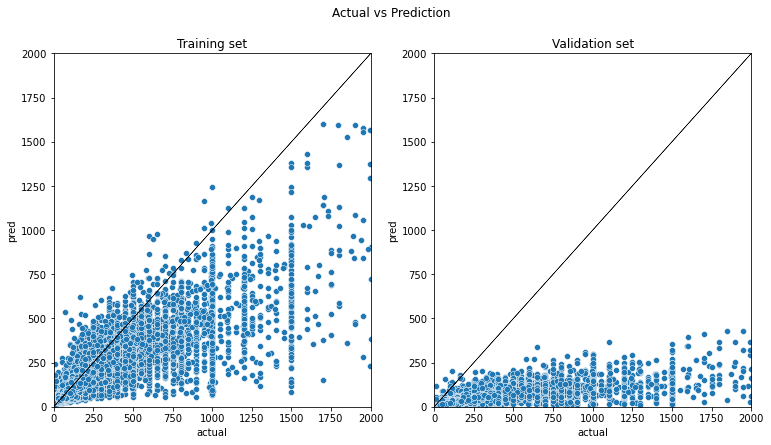

In [28]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

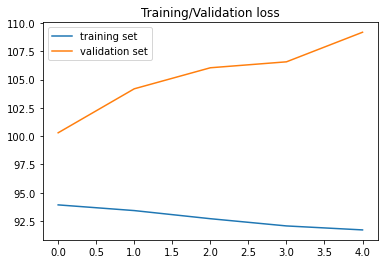

In [29]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [30]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [32]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

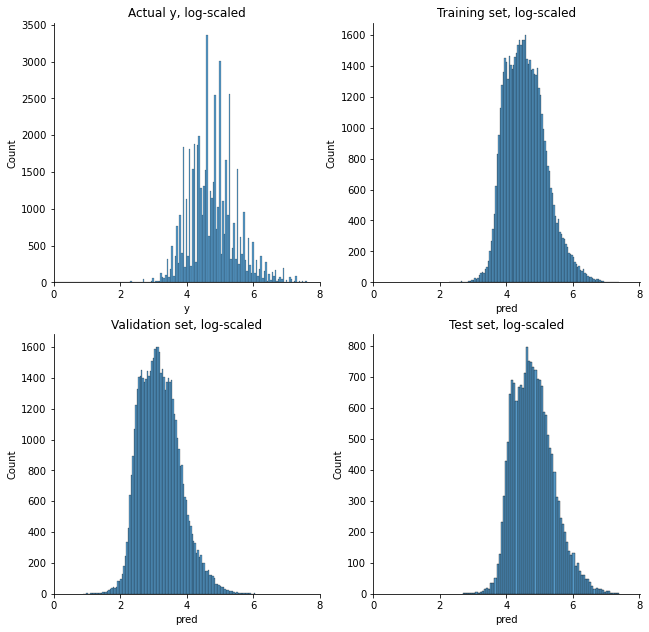

In [33]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [34]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [35]:
pd.options.display.float_format = '{:.5f}'.format

In [36]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

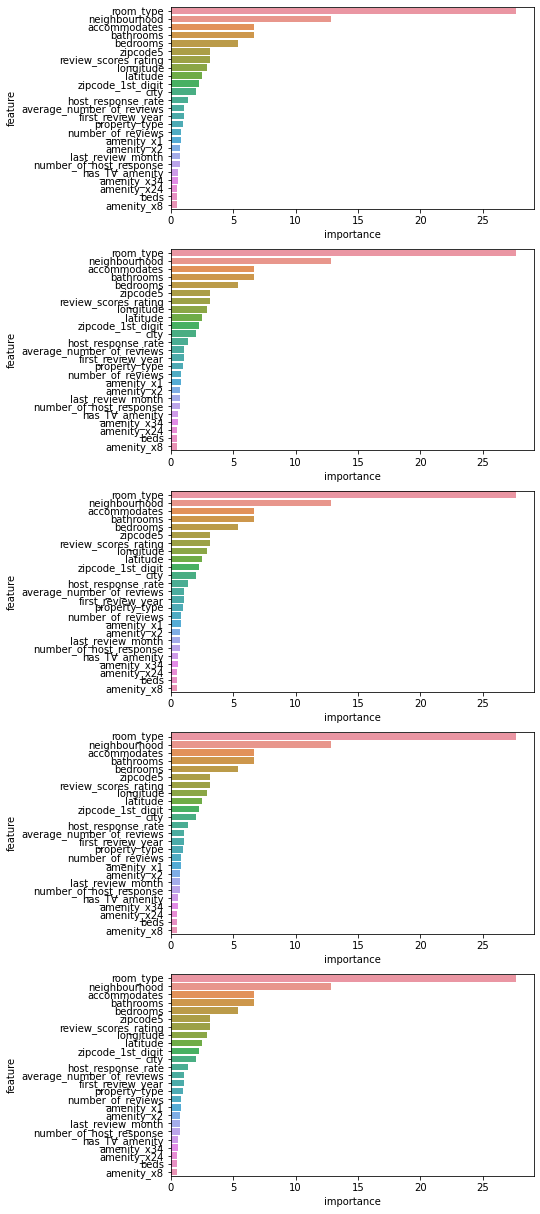

In [37]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
    imp_df['feature'] = model.feature_names_
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance.png'))

# Error

In [38]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [39]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

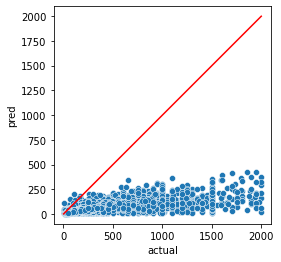

In [40]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

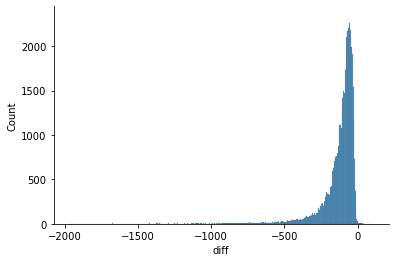

In [41]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [42]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [43]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\03-02\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 1min 9s


In [44]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [45]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [46]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [47]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [48]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                             -0.47720
bedrooms                                 -0.45313
bathrooms                                -0.41762
beds                                     -0.39679
room_type                                -0.26861
has_Familykid-friendly_amenity           -0.19145
has_Indoor-fireplace_amenity             -0.16667
has_TV_amenity                           -0.16139
has_Cable-TV_amenity                     -0.15579
has_Dryer_amenity                        -0.14244
has_Washer_amenity                       -0.13944
amenity_x1                               -0.13751
has_Suitable-for-events_amenity          -0.13570
amenity_x3                               -0.11454
has_thumbnail                            -0.11180
has_Hot-tub_amenity                      -0.07614
has_Gym_amenity                          -0.07517
has_Pool_amenity                         -0.07298
has_Doorman_amenity                      -0.07068
has_Free-parking-on-premises_amenity     -0.06659


In [49]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [50]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [51]:
imp_df['feature'] = estimator.feature_name_

In [52]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df.head(25)

,importance,feature
3,981071364.50000,bedrooms
1,605618392.50000,bathrooms
0,506426097.89844,accommodates
13,296704371.60938,longitude
12,272864520.19922,latitude
18,246188243.00000,room_type
155,115501760.00000,last_review_year
144,73094834.00000,average_number_of_reviews
10,49764694.29688,host_response_rate
17,49305410.00000,review_scores_rating


In [53]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)